# calculates the seasonal anomalies and the seasonal tercile categories from the gridded VCSN monthly files, using the NZ 6 regions shapefiles 

In [214]:
# Paramaters 

var_name = 'Rain_bc'
# var_name = 'Tmin_N'
# var_name = 'Tmax_N'
# var_name = 'Tmean_N'
# var_name = 'SoilM'
# var_name = 'Wind'
# var_name = 'Rad'

in ['Agent', 'Lat', 'Longt', 'Date', 'MSLP', 'PET', 'Rain', 'RH', 'SoilM',
       'ETmp', 'Rad', 'TMax', 'Tmin', 'VP', 'Wind', 'Rain_bc', 'Tmax_N',
       'Tmin_N']

In [215]:
import os
import sys
import pathlib

In [216]:
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import geopandas as gpd

In [217]:
import xarray as xr

In [218]:
from calendar import month_abbr

In [219]:
sys.path.append('/home/nicolasf/research/Smart_Ideas/resources/repos_libraries/xclim')

In [220]:
import cartopy.crs as ccrs

In [221]:
import xclim

In [222]:
big_var = var_name.split('_')[0].upper()

In [223]:
big_var

'RAIN'

In [224]:
HOME = pathlib.Path.home()

In [225]:
dpath = HOME / 'operational/VCSN/data/NC/DAILY/' / var_name.upper()

In [226]:
var_name.upper()

'RAIN_BC'

In [227]:
dpath

PosixPath('/home/nicolasf/operational/VCSN/data/NC/DAILY/RAIN_BC')

In [228]:
lfiles_vcsn = list(dpath.glob("*.nc"))

In [229]:
lfiles_vcsn.sort()

In [230]:
len(lfiles_vcsn)

492

In [231]:
lfiles_vcsn[0]

PosixPath('/home/nicolasf/operational/VCSN/data/NC/DAILY/RAIN_BC/VCSN_gridded_daily_Rain_bc_1979-01.nc')

In [232]:
lfiles_vcsn[-1]

PosixPath('/home/nicolasf/operational/VCSN/data/NC/DAILY/RAIN_BC/VCSN_gridded_daily_Rain_bc_2019-12.nc')

### open the dataset using xarray 

In [233]:
dset = xr.open_mfdataset(lfiles_vcsn, concat_dim='time')

In [234]:
dset

<xarray.Dataset>
Dimensions:  (lat: 257, lon: 241, time: 14975)
Coordinates:
  * lon      (lon) float64 166.5 166.5 166.6 166.6 ... 178.3 178.4 178.4 178.5
  * lat      (lat) float64 -47.27 -47.23 -47.17 -47.12 ... -34.52 -34.48 -34.42
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-12-31
Data variables:
    Rain_bc  (time, lat, lon) float64 dask.array<chunksize=(31, 257, 241), meta=np.ndarray>
    agent    (time, lat, lon) float32 dask.array<chunksize=(31, 257, 241), meta=np.ndarray>
    mask     (time, lat, lon) float64 dask.array<chunksize=(31, 257, 241), meta=np.ndarray>

### add units 

In [238]:
dset[var_name].attrs['units'] = 'mm/day'

In [44]:
quarters = [f"Q-{x.upper()}" for x in month_abbr[1:]]

In [51]:
quarters

['Q-JAN',
 'Q-FEB',
 'Q-MAR',
 'Q-APR',
 'Q-MAY',
 'Q-JUN',
 'Q-JUL',
 'Q-AUG',
 'Q-SEP',
 'Q-OCT',
 'Q-NOV',
 'Q-DEC']

### try calculating the number of dry days per months using xclim 

In [145]:
dd = xclim.atmos.dry_days(dset[var_name], thresh = '0.1 mm/day', freq = 'M')

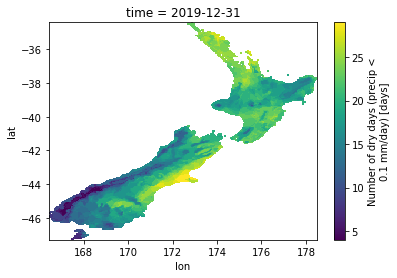

In [146]:
dd[-1,:,:].plot()

### compare with 'naive' version just using the xr.where mechanism 

In [152]:
sub = dset.sel(time='2019-12')

In [153]:
sub

<xarray.Dataset>
Dimensions:  (lat: 257, lon: 241, time: 31)
Coordinates:
  * lon      (lon) float64 166.5 166.5 166.6 166.6 ... 178.3 178.4 178.4 178.5
  * lat      (lat) float64 -47.27 -47.23 -47.17 -47.12 ... -34.52 -34.48 -34.42
  * time     (time) datetime64[ns] 2019-12-01 2019-12-02 ... 2019-12-31
Data variables:
    Rain_bc  (time, lat, lon) float64 dask.array<chunksize=(31, 257, 241), meta=np.ndarray>
    agent    (time, lat, lon) float32 dask.array<chunksize=(31, 257, 241), meta=np.ndarray>
    mask     (time, lat, lon) float64 dask.array<chunksize=(31, 257, 241), meta=np.ndarray>

In [154]:
sub = sub[[var_name]]

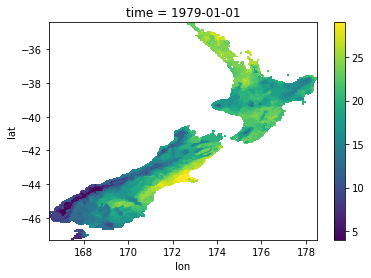

In [160]:
((sub.where(sub[var_name] < 0.1).count('time')['Rain_bc']) * dset['mask'][0,:,:]).plot()

In [161]:
from dateutil.relativedelta import relativedelta

In [162]:
from datetime import datetime

In [164]:
start = datetime(1979,1,1) 

In [168]:
start + relativedelta(months=3) - relativedelta(days=1)

datetime.datetime(1979, 3, 31, 0, 0)

In [169]:
sub_t = dset.sel(time=slice(start, start + relativedelta(months=3) - relativedelta(days=1)))

In [172]:
sub_t.time[0]

<xarray.DataArray 'time' ()>
array('1979-01-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 1979-01-01

In [173]:
sub_t.time[-1]

<xarray.DataArray 'time' ()>
array('1979-03-31T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 1979-03-31

In [193]:
dd = xclim.indices.dry_days(sub_t[var_name], thresh = '0.1 mm/day', freq = 'YS')

### This below DOESNT work, because all the methods of the class atmos will check for missing values

```
dd = xclim.atmos.dry_days(sub_t[var_name], thresh = '0.1 mm/day', freq = 'YS')
```

### recode the time 

In [194]:
dd['time'] = [start + relativedelta(months=3) - relativedelta(days=1)]

In [195]:
dd

<xarray.DataArray 'Rain_bc' (time: 1, lat: 257, lon: 241)>
dask.array<copy, shape=(1, 257, 241), dtype=int64, chunksize=(1, 257, 241), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1979-03-31
  * lon      (lon) float64 166.5 166.5 166.6 166.6 ... 178.3 178.4 178.4 178.5
  * lat      (lat) float64 -47.27 -47.23 -47.17 -47.12 ... -34.52 -34.48 -34.42
Attributes:
    units:    days

In [197]:
dd = dd * dset['mask'][0,:,:]

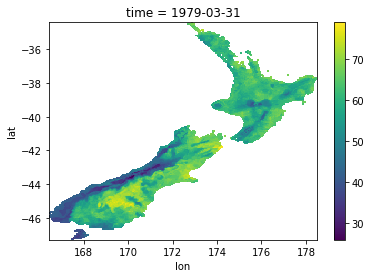

In [198]:
dd[0,:,:].plot()

### now loops from 1st month to 3rd to last month 

In [199]:
dset

<xarray.Dataset>
Dimensions:  (lat: 257, lon: 241, time: 14975)
Coordinates:
  * lon      (lon) float64 166.5 166.5 166.6 166.6 ... 178.3 178.4 178.4 178.5
  * lat      (lat) float64 -47.27 -47.23 -47.17 -47.12 ... -34.52 -34.48 -34.42
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-12-31
Data variables:
    Rain_bc  (time, lat, lon) float64 dask.array<chunksize=(31, 257, 241), meta=np.ndarray>
    agent    (time, lat, lon) float32 dask.array<chunksize=(31, 257, 241), meta=np.ndarray>
    mask     (time, lat, lon) float64 dask.array<chunksize=(31, 257, 241), meta=np.ndarray>

### create a monthly calendar, from the first month to the 3rd to last month

In [211]:
dates = pd.date_range(start=pd.to_datetime(dset.time[0].data), end=pd.to_datetime(dset.time[-1].data), freq='MS')[0:-2]

In [244]:
dd_l = []

for date in dates: 
    
    sub_t = dset.sel(time=slice(date, date + relativedelta(months=3) - relativedelta(days=1)))
    
    # here trick xclim to think it is all in the same year :-) 
    sub_t['time'] = pd.date_range(start='1979-1-1', periods=len(sub_t.time.data), freq='D')
    
    # calculate the index 
    dd = xclim.indices.dry_days(sub_t[var_name], thresh = '0.1 mm/day', freq = 'YS')
    
    # multiply by the mask 
    dd = dd * dset['mask'][0,:,:]
    
    # set the date to be the last date of the 3 months period 
    dd['time'] = [date + relativedelta(months=3) - relativedelta(days=1)]
    
    dd_l.append(dd)

### concatenate along the time dimension 

In [250]:
dd_l = xr.concat(dd_l, dim='time')

In [258]:
dd_l

<xarray.DataArray (time: 490, lat: 257, lon: 241)>
dask.array<concatenate, shape=(490, 257, 241), dtype=float64, chunksize=(1, 257, 241), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 166.5 166.5 166.6 166.6 ... 178.3 178.4 178.4 178.5
  * lat      (lat) float64 -47.27 -47.23 -47.17 -47.12 ... -34.52 -34.48 -34.42
  * time     (time) datetime64[ns] 1979-03-31 1979-04-30 ... 2019-12-31

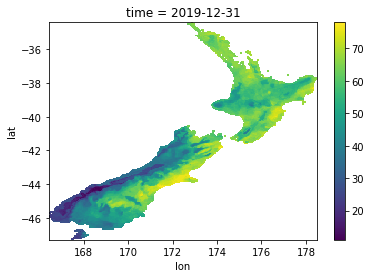

In [260]:
dd_l[-1,:,:].plot()